In [30]:
import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [31]:
df = pd.read_excel("../data/processed/exploratory_analysis_final.xlsx")

In [32]:
# Replace missing QS rank with a low prestige value (e.g., rank 1200)
df['qs_rank'] = df['qs_rank'].fillna(1200)
df['qs_rank_score'] = -df['qs_rank']

In [33]:
# === Final Feature List ===
feature_cols = [
    'acceptance_rate',
    'undergrad_gpa',
    'gre_quantitative_reasoning',
    'gre_verbal_reasoning',
    'analytical_writing',
    'gre_total',
    'gpa_percentile',
    'gre_avg',
    'gpa_x_acceptancerate',
    'application_strength',
    'qs_rank',
    'qs_rank_score',
    'qs_tier',
    'tier_score',
    'program',
    'degree_type',
    'institution'
]


In [34]:
# Features and target
X = df[feature_cols]
y = df['decision_grouped']

In [35]:
# Split and oversample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [ ]:
# Base models including classifiers and regressors
base_models = [
    ('rf_class', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
    ('xgb_class', XGBClassifier(random_state=42, eval_metric='mlogloss')),
    ('rf_reg', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb_reg', XGBRegressor(random_state=42)),
    ('lr', LinearRegression())
]

In [37]:
# Meta-model
meta_model = LogisticRegression(max_iter=1000)

In [38]:
# Stacking ensemble
stacked_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)


In [39]:
# Train and evaluate
stacked_clf.fit(X_train_sm, y_train_sm)
y_pred = stacked_clf.predict(X_test)


In [40]:
print("Ensemble Stacking Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Ensemble Stacking Accuracy: 0.5323726708074534
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.57      0.58      7440
           1       0.53      0.55      0.54      7095
           2       0.45      0.46      0.46      5590

    accuracy                           0.53     20125
   macro avg       0.53      0.53      0.53     20125
weighted avg       0.53      0.53      0.53     20125

Confusion Matrix:
 [[4243 1675 1522]
 [1599 3879 1617]
 [1255 1743 2592]]


decision_grouped
0    37245
1    35986
2    27390
Name: count, dtype: int64


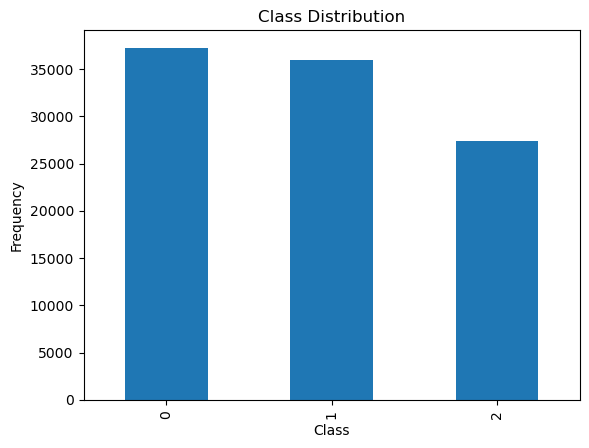

In [41]:
# Check class distribution
class_counts = df['decision_grouped'].value_counts()

# Display the class distribution
print(class_counts)

# Optionally, you can plot the class distribution for better visualization
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()
